In [1]:
!pip install neurokit2
!pip install wfdb
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 14.6 MB/s eta 0:00:00


In [2]:
import neurokit2 as nk
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

In [3]:
#Load dataset from drive
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/mit-bih-merge'

Mounted at /content/drive


In [4]:
warnings.filterwarnings('ignore')

# Load the record and annotation
data = '/content/drive/MyDrive/mit-bih-merge/'

In [5]:
# Get the list of all record files in the folder
# List of Patients
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234',
            '04015', '04043', '04048', '04126', '04746',
            '04908', '04936', '05091', '05121', '05261',
            '06426', '06453', '06995', '07162', '07859',
            '07879', '07910', '08215', '08219', '08378',
            '08405', '08434', '08455']


In [6]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

In [7]:
# Reading all .atr files
# Dataset MIT-BIH MITDB
for pts in patients:
    # Generating filepath for all .atr file names
    file = data + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'Patient Number':[pts]*len(counts)})
    # Concatenating all data points
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

In [10]:
# Loop untuk membaca seluruh rekaman dan memuat sinyal dan anotasi
# Membuat list kosong untuk menyimpan data anotasi
annotations_data = []

# Loop over all records and load the signal and annotations
for record_name in patients:
    record_path = os.path.join(data, record_name)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr', shift_samps=True)
    ecg_signal = record.p_signal[:,0]
    ecg_signal = np.nan_to_num(ecg_signal)

    # Get the signal and labels
    sig = ecg_signal
    labels = np.array(annotation.symbol)
    sample_indices = annotation.sample

    # Cari indeks anotasi dengan simbol 'f', 'A', dan 'V'
    indices_f = np.where(labels == 'f')[0]
    indices_A = np.where(labels == 'A')[0]
    indices_V = np.where(labels == 'V')[0]
    indices_selected = np.concatenate((indices_f, indices_A, indices_V))

    # Dapatkan indeks sampel dan konversikan ke waktu
    selected_labels = labels[indices_selected]
    selected_sample_indices = sample_indices[indices_selected]
    sampling_frequency = record.fs
    time_indices = selected_sample_indices / sampling_frequency

    # Menyimpan data anotasi dalam bentuk tuple
    for i in range(len(selected_labels)):
        annotations_data.append((record_name, selected_labels[i], selected_sample_indices[i], time_indices[i]))

# Membuat dataframe dari data anotasi
annotations_df = pd.DataFrame(annotations_data, columns=['Patient Number', 'Symbol', 'Sample Index', 'Time (s)'])

# Menyimpan dataframe sebagai file CSV
annotations_df.to_csv('annotations.csv', index=False)

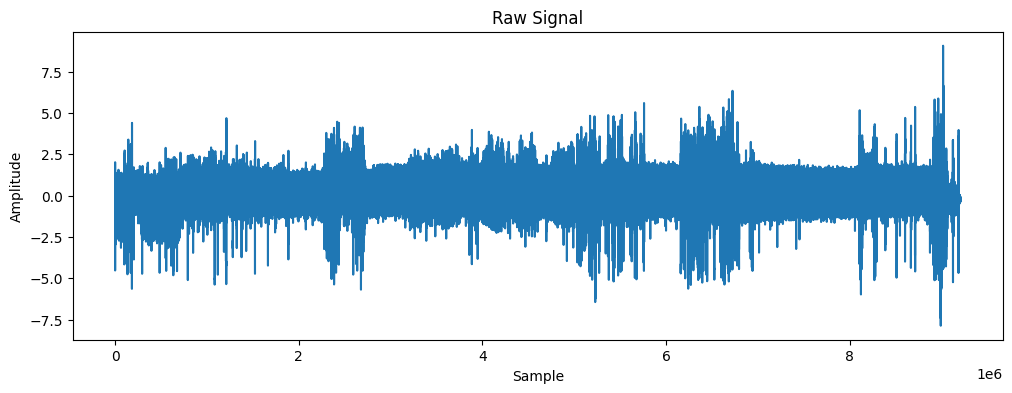

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Raw Signal')
plt.show()

In [12]:
# Check if there are any NaN values in the ecg_signal variable
if np.isnan(sig).any():
    print("There are NaN values in the ecg_signal variable.")
else:
    print("There are no NaN values in the ecg_signal variable.")

There are no NaN values in the ecg_signal variable.


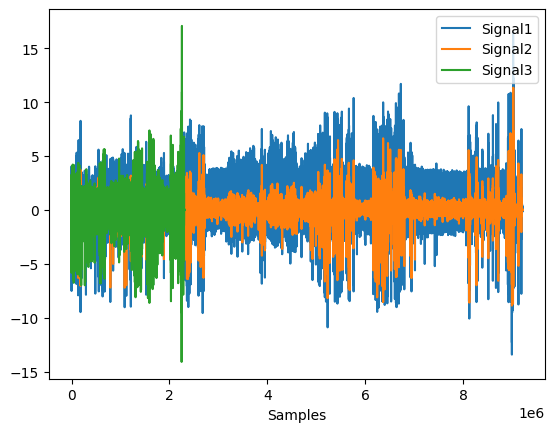

In [13]:
from scipy.signal import resample, find_peaks

# Normalize the data
signal = (sig - np.mean(sig)) / np.std(sig)

# Resample the data to new_sampling_rate
new_sampling_rate = 250
record = {"fs": 1000}  # Define the sampling rate
sig_resampled = resample(signal, int(len(signal) * (new_sampling_rate / record["fs"])))

# Distort the signal using a cubic spline
distorted = nk.signal_distort(signal, sampling_rate=new_sampling_rate, powerline_amplitude=0.4)

# Detrend the signal using a cubic polynomial
cleaned = nk.signal_detrend(distorted, order=3)
cleaned = nk.signal_filter(cleaned, lowcut= 0.5, highcut= 10)

# Filter the signal using a Butterworth bandpass filter (0.5-40 Hz)
signal_filtered = nk.signal_filter(sig_resampled,
                           lowcut=0.5,
                           highcut=40,
                           sampling_rate=new_sampling_rate,
                           method='butterworth',
                           order=2)

# Compare the 3 signals
plot = nk.signal_plot([distorted, cleaned, signal_filtered])

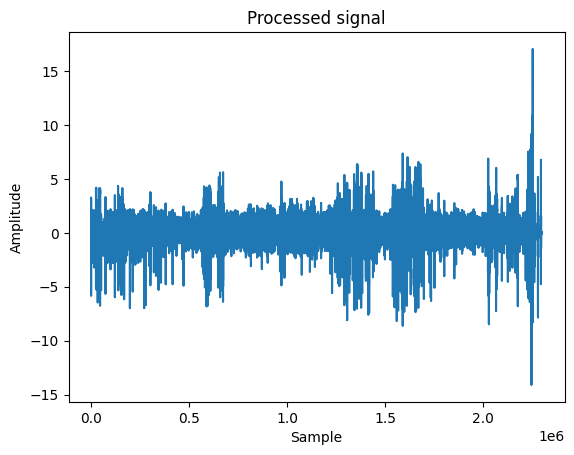

In [14]:
# Visualize the processed signal
plt.plot(signal_filtered)
plt.title("Processed signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

In [15]:
#find the peaks
from scipy.signal import resample, butter, filtfilt, find_peaks

# Find the R-peaks
rpeaks, _ = find_peaks(signal_filtered, height=0.5, distance=50)

# create array for marking detected peaks
peaks = np.zeros_like(signal_filtered)

# mark R-peaks
peaks[rpeaks] = signal_filtered[rpeaks]

# detect P-peaks
p_peaks, _ = find_peaks(signal_filtered[:rpeaks[0]], height=0.1, distance=50)

p_peak = p_peaks[-1] if len(p_peaks) > 0 else None

# detect Q-peaks
if p_peak is not None:
    q_peaks, _ = find_peaks(-signal_filtered[p_peak:rpeaks[0]], height=-0.2, distance=50)
    q_peak = p_peak + q_peaks[-1] if len(q_peaks) > 0 else None
else:
    q_peak = None

# detect S-peaks
s_peaks, _ = find_peaks(-signal_filtered[rpeaks[0]:rpeaks[1]], height=-0.2, distance=50)
s_peak = rpeaks[0] + s_peaks[0] if len(s_peaks) > 0 else None

# detect T-peaks
t_peaks, _ = find_peaks(signal_filtered[rpeaks[1]:], height=0.1, distance=50)
t_peak = rpeaks[1] + t_peaks[0] if len(t_peaks) > 0 else None

# detect P-peaks
p_peaks, _ = find_peaks(signal_filtered[:rpeaks[0]], height=0.1, distance=50)

# modify conditional statements
if p_peak is not None and len(p_peaks) > 0:
    q_peaks, _ = find_peaks(-signal_filtered[p_peak:rpeaks[0]], height=-0.2, distance=50)
    q_peak = p_peak + q_peaks[-1]
else:
    q_peak = None

if len(s_peaks) > 0:
    s_peak = rpeaks[0] + s_peaks[0]
else:
    s_peak = None

if len(t_peaks) > 0:
    t_peak = rpeaks[1] + t_peaks[0]
else:
    t_peak = None

Signal shape: (2301440,)
Labels shape: (4,)


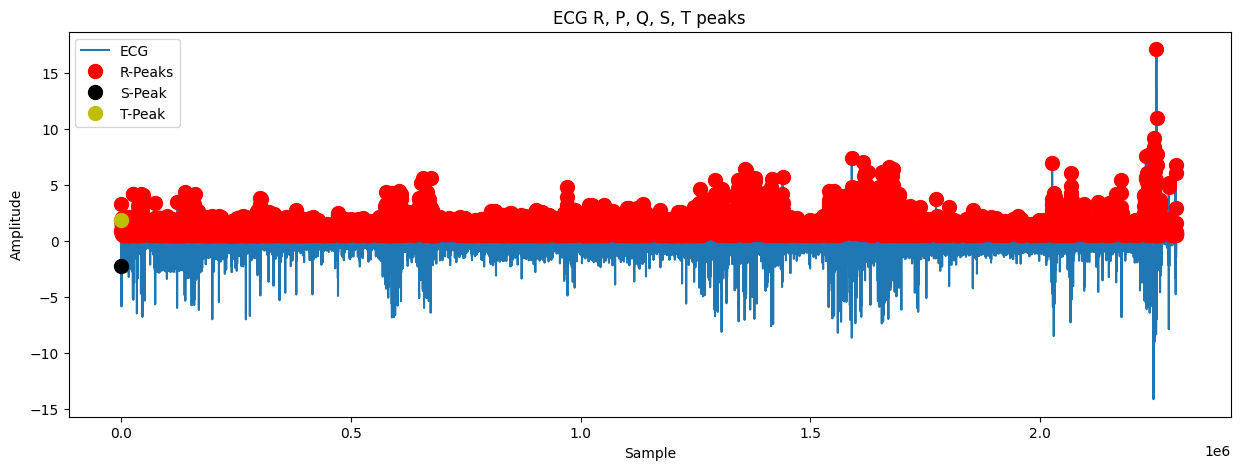

In [16]:
#denoising
import pywt
from scipy import integrate

def wavelet_denoising(data_sample):
    waveletname = 'db6'
    threshold = 0.04
    level = pywt.dwt_max_level(len(data_sample), waveletname)
    coeff = pywt.wavedec(data_sample, waveletname, level=level)
    sigma = threshold*np.median(np.abs(coeff[-level]))
    uthresh = sigma*np.sqrt(2*np.log(len(data_sample)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, waveletname)
    return reconstructed_signal

signal_denoised = wavelet_denoising(signal_filtered)

# Define signal parameters
fs = 1000  # Sampling frequency
f = 500  # ECG frequency
duration = 10  # Signal duration (in seconds)

# Generate time vector
t = np.arange(0, duration, 1/fs)

# Generate ECG signal
sig = integrate.cumulative_trapezoid(np.sin(2*np.pi*f*t), t, initial=0)


# Print the shape of the signal and labels
print("Signal shape:", signal_denoised.shape)
print("Labels shape:", labels.shape)

# plot ECG signal with R-peaks
plt.figure(figsize=(15, 5))
plt.plot(signal_filtered, label='ECG')
plt.plot(rpeaks, peaks[rpeaks], 'or', markersize=10, label='R-Peaks', linestyle='None')

# plot P, Q, S, T peaks
if p_peak is not None:
  plt.plot(p_peak, signal_filtered[p_peak], 'og', markersize=10, label='P-Peak', linestyle='None')
if q_peak is not None:
  plt.plot(q_peak, signal_filtered[q_peak], 'ob', markersize=10, label='Q-Peak', linestyle='None')
if s_peak is not None:
  plt.plot(s_peak, signal_filtered[s_peak], 'ok', markersize=10, label='S-Peak', linestyle='None')
if t_peak is not None:
  plt.plot(t_peak, signal_filtered[t_peak], 'oy', markersize=10, label='T-Peak', linestyle='None')

plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG R, P, Q, S, T peaks')
plt.legend()
plt.show()


In [17]:
# Symbols Dataframe
symbols_df

,symbol,Counts,Patient Number
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101
...,...,...,...
0,+,79,08219
0,+,17,08378
0,+,4,08405
0,+,7,08434


In [18]:
# Value Counts of Different symbols in data
symbols_df.groupby('symbol').Counts.sum().sort_values(ascending = False)

symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1896
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Counts, dtype: int64

In [19]:
# Abnormal Beat Symbols
AF = ['f']
PAC = ['A']
PVC = ['V']

abnormal_category = AF + PAC + PVC

In [20]:
# Classifying abnormal beats into more specific categories
symbols_df.loc[symbols_df.symbol.isin(AF), 'abnormal_category'] = "AF"
symbols_df.loc[symbols_df.symbol.isin(PAC), 'abnormal_category'] = "PAC"
symbols_df.loc[symbols_df.symbol.isin(PVC), 'abnormal_category'] = "PVC"

In [21]:
# Value counts of different categories
symbols_df.groupby('abnormal_category').Counts.sum()

abnormal_category
AF      982
PAC    2546
PVC    7130
Name: Counts, dtype: int64

In [22]:
def load_ecg(file):
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')

    # extracting the signal
    p_signal = record.p_signal

    # extracting symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample

In [23]:
# Accessing the ecg points for
file = data + patients[8]

In [24]:
# Accessing the load ECG function and getting annotation.symbol, annotation.sample, signals
p_signal, atr_sym, atr_sample = load_ecg(file)

In [25]:
# Analysing annotations value counts for a single record
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 4


In [26]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal_category][:10]
ab_index

[4105, 10876, 83824, 107330, 180041, 193553, 205731, 221206, 263192, 268697]

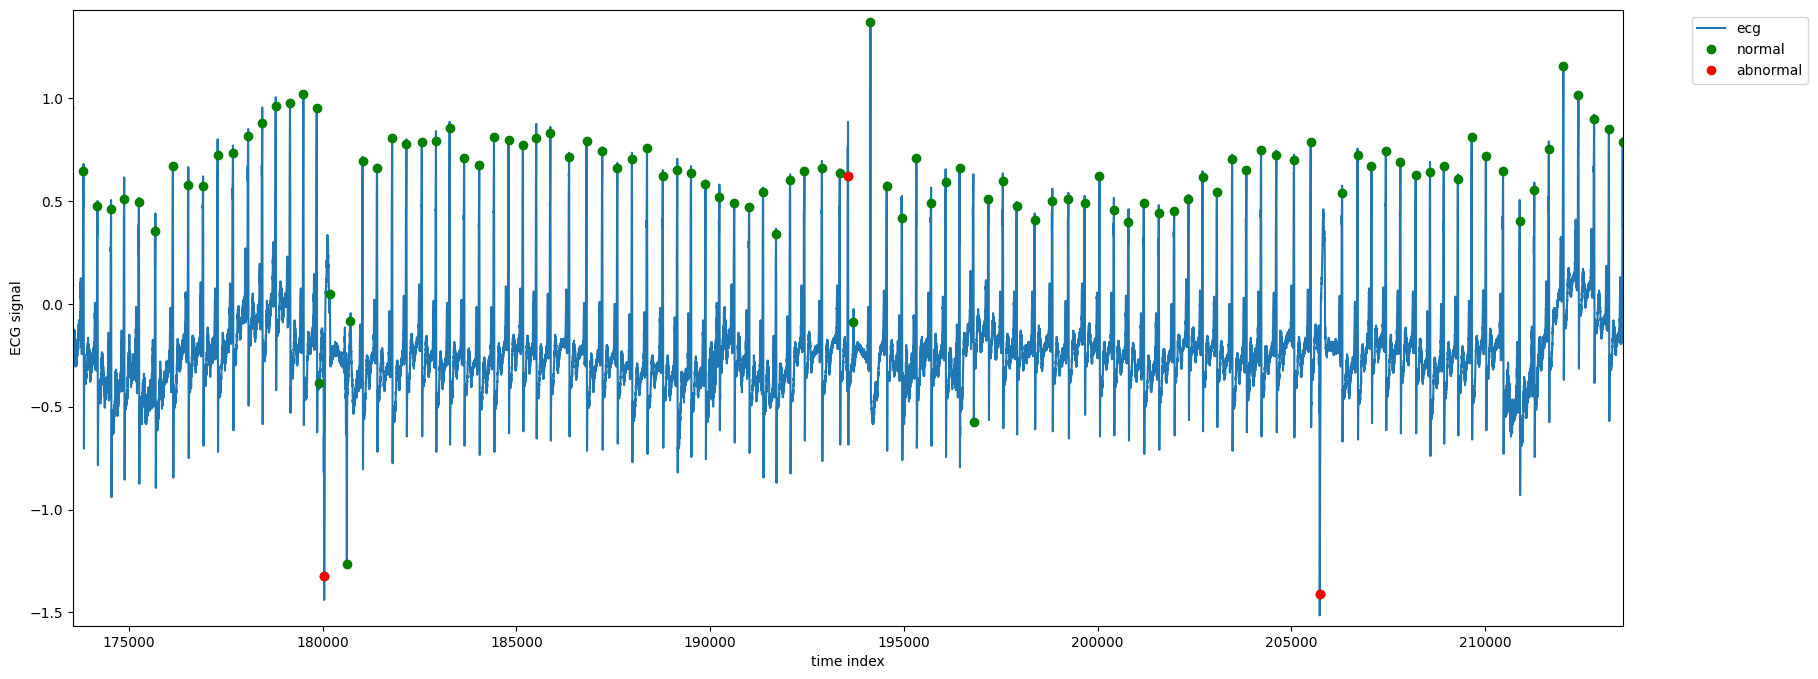

In [27]:
# Generating evenly spaced values
x = np.arange(len(p_signal))

left = ab_index[5]-20000
right = ab_index[5]+20000

if left < 0:
    left = 0
if right > len(p_signal):
    right = len(p_signal)

if left >= right:
    raise ValueError("Invalid range specified")

plt.figure(figsize=(20,8))
plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right,0].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

In [28]:
def make_dataset(record_patients, num_sec, fs, abnormal_category):

    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,len(abnormal_category)))
    sym_all = []

    # list to keep track of number of beats across patients
    max_rows = []

    for pt in patients:
        file = data + pt

        p_signal, atr_sym, atr_sample = load_ecg(file)

        # grab the first signal
        p_signal = p_signal[:,0]

        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal_category)]

        num_rows = len(df_ann)

        X = np.zeros((num_rows, num_cols))
        Y = np.zeros((num_rows, len(abnormal_category)))
        sym = []

        # keep track of rows
        max_row = 0

        for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

            left = max([0,(atr_sample - num_sec*fs) ])
            right = min([len(p_signal),(atr_sample + num_sec*fs) ])
            x = p_signal[left: right]
            if len(x) == num_cols:
                X[max_row,:] = x
                Y[max_row, abnormal_category.index(atr_sym)] = 1
                sym.append(atr_sym)
                max_row += 1
        X = X[:max_row,:]
        Y = Y[:max_row,:]

        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)

    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    return X_all, Y_all, sym_all

  abnormal_category  Counts
0                AF     982
1               PAC    2546
2               PVC    7130


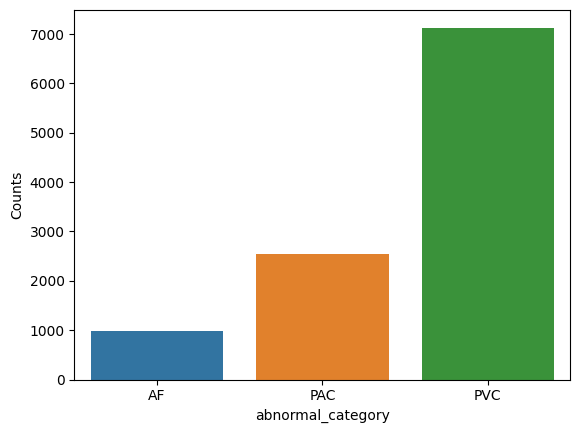

In [29]:
import seaborn as sns
# Value counts of different categories
counts_df = symbols_df.groupby('abnormal_category')['Counts'].sum().reset_index()
print(counts_df)

# Visualize the number of subjects in each abnormal_category:
sns.barplot(x='abnormal_category', y='Counts', data=counts_df)
plt.show()

In [ ]:
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.fft import fft

def extract_features(rr_intervals):
    features = {}

    # RR Interval Features
    rr_mean = np.mean(rr_intervals)
    rr_std = np.std(rr_intervals)
    rr_min = np.min(rr_intervals)
    rr_max = np.max(rr_intervals)
    rr_range = rr_max - rr_min
    rr_median = np.median(rr_intervals)
    rr_diff = np.diff(rr_intervals)
    rr_fft = np.abs(fft(rr_intervals))
    rr_skewness = skew(rr_intervals)
    rr_kurtosis = kurtosis(rr_intervals)

    features['RR Mean'] = rr_mean
    features['RR Std'] = rr_std
    features['RR Min'] = rr_min
    features['RR Max'] = rr_max
    features['RR Range'] = rr_range
    features['RR Median'] = rr_median
    features['RR Skewness'] = rr_skewness
    features['RR Kurtosis'] = rr_kurtosis

    features['mean_rr_diff'] = np.mean(rr_diff)
    features['std_rr_diff'] = np.std(rr_diff)
    features['min_rr_diff'] = np.min(rr_diff)
    features['max_rr_diff'] = np.max(rr_diff)
    features['median_rr_diff'] = np.median(rr_diff)
    features['range_rr_diff'] = np.ptp(rr_diff)

    features['RR FFT Mean'] = np.mean(rr_fft)
    features['RR FFT Std'] = np.std(rr_fft)
    features['RR FFT Max'] = np.max(rr_fft)

    rr_variance = np.var(rr_intervals)
    rr_coefficient_of_variation = np.mean(rr_intervals) / np.std(rr_intervals)

    features['RR Variance'] = rr_variance
    features['RR Coefficient of Variation'] = rr_coefficient_of_variation

    # Additional Statistical Features
    features['RR 5th Percentile'] = np.percentile(rr_intervals, 5)
    features['RR 95th Percentile'] = np.percentile(rr_intervals, 95)
    features['RR Interquartile Range'] = np.percentile(rr_intervals, 75) - np.percentile(rr_intervals, 25)

    # Additional Dynamic Features
    rr_diff_mean = np.mean(rr_diff)
    rr_diff_std = np.std(rr_diff)
    rr_diff_min = np.min(rr_diff)
    rr_diff_max = np.max(rr_diff)
    rr_diff_median = np.median(rr_diff)
    rr_diff_range = np.ptp(rr_diff)

    features['mean_rr_diff'] = rr_diff_mean
    features['std_rr_diff'] = rr_diff_std
    features['min_rr_diff'] = rr_diff_min
    features['max_rr_diff'] = rr_diff_max
    features['median_rr_diff'] = rr_diff_median
    features['range_rr_diff'] = rr_diff_range


    return features

In [ ]:
  # Parameter Values
num_sec = 3
fs = 360

# Accessing the function and creating a dataset with ECG digital points
X_all, Y_all, sym_all = make_dataset(patients, num_sec, fs, abnormal_category)

# Mengambil segmen RR interval
rr_intervals = X_all[:, fs * num_sec:]

features = []
for rr in rr_intervals:
    feature = extract_features(rr)
    features.append(feature)

# Convert the features list to a dataframe
df_features = pd.DataFrame(features)

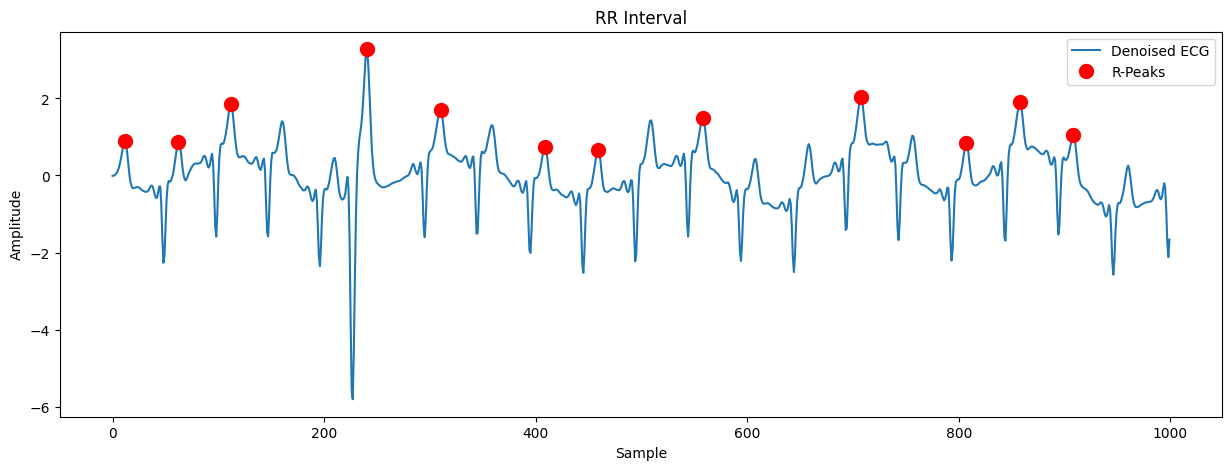

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Panjang sampel
sample_length = 1000

# Mengambil hanya sampel pertama sepanjang sample_length dari sinyal denoised
denoised_sample = signal_denoised[:sample_length]

# Membuat array untuk menandai puncak R pada sampel yang dipilih
rpeaks_sample = rpeaks[rpeaks < sample_length]

# Membuat array untuk menandai puncak R pada sinyal denoised
denoised_rpeaks = np.zeros_like(denoised_sample)
denoised_rpeaks[rpeaks_sample] = denoised_sample[rpeaks_sample]

# Plot sinyal denoised dengan puncak R
plt.figure(figsize=(15, 5))
plt.plot(denoised_sample, label='Denoised ECG')
plt.plot(rpeaks_sample, denoised_rpeaks[rpeaks_sample], 'or', markersize=10, label='R-Peaks', linestyle='None')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('RR Interval')
plt.legend()
plt.show()

In [ ]:
# Get the number of abnormal categories
num_classes = Y_all.shape[1]

# Get the classes as a list of strings
abnormal_classes = ['class ' + str(i) for i in range(num_classes)]

# Get the index of the max value for each row in Y_all (i.e. the predicted class)
predicted_classes = np.argmax(Y_all, axis=1)

# Get the actual class for each row in Y_all (i.e. the ground truth)
actual_classes = [abnormal_classes[index] for index in predicted_classes]

# Print the first 10 rows of Y_all, predicted_classes, and actual_classes
print('Y_all (first 10 rows):\n', Y_all[:10])
print('predicted_classes (first 10):\n', predicted_classes[:10])
print('actual_classes (first 10):\n', actual_classes[:10])

Y_all (first 10 rows):
 [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
predicted_classes (first 10):
 [1 1 1 1 1 1 1 1 1 1]
actual_classes (first 10):
 ['class 1', 'class 1', 'class 1', 'class 1', 'class 1', 'class 1', 'class 1', 'class 1', 'class 1', 'class 1']


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from scipy import signal as sig
from sklearn.metrics import confusion_matrix, recall_score
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Flatten, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity


# Convert the features list to a dataframe
df_features = pd.DataFrame(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_features, Y_all, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input features for CNN
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define learning rate
learning_rate = 0.001

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Define the model
num_classes
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_reshaped.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Dense(num_classes, activation='softmax'))
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with binary crossentropy, adam optimizer, and custom metrics
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', specificity])

# Convert multilabel-indicator to multiclass
label_encoder = LabelEncoder()
y_train_multiclass = np.argmax(y_train, axis=1)
y_train_multiclass = label_encoder.fit_transform(y_train_multiclass)

# Convert multiclass labels to one-hot encoding
num_classes = len(abnormal_category)
y_train_onehot = to_categorical(y_train_multiclass, num_classes=num_classes)

# Define the number of folds for cross-validation
num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# Initialize lists to store the results
acc_per_fold = []
loss_per_fold = []
spec_per_fold = []
sens_per_fold = []
classification_reports = []
confusion_matrics = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, val_index in kfold.split(X_train_reshaped, y_train_multiclass):
    train_X, val_X = X_train_reshaped[train_index], X_train_reshaped[val_index]
    train_y, val_y = y_train_onehot[train_index], y_train_onehot[val_index]
    # Fit the model on the current fold's training data, with early stopping
    history = model.fit(train_X, train_y, batch_size=64, epochs=100, callbacks=[early_stopping], validation_data=(val_X, val_y))

    # Evaluate the model on the current fold's test data
    scores = model.evaluate(val_X, val_y)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]} of {scores[2]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    spec_per_fold.append(scores[2] * 100)


    # Make predictions on validation set
    Y_pred = model.predict(val_X)
    Y_pred_labels = np.argmax(Y_pred, axis=1)
    Y_true_labels = np.argmax(val_y, axis=1)

    #calculate sensitifity
    sensitivity = recall_score(Y_true_labels, Y_pred_labels, average='macro')
    sens_per_fold.append(sensitivity * 100)

    # Generate classification report and confusion matrix for the current fold
    report = classification_report(Y_true_labels, Y_pred_labels, target_names= abnormal_category)
    # report += f"\nSpecificity: {spec:.2f}"
    confusion = confusion_matrix(Y_true_labels, Y_pred_labels)
    classification_reports.append(report)
    confusion_matrics.append(confusion)
    mean_conf_matrix = np.sum(confusion_matrics, axis=0)

    # Calculate sensitivity for every abnormal_category
    sensitivities = []
    for i in range(len(abnormal_category)):
        true_positives = mean_conf_matrix[i, i]
        false_negatives = np.sum(mean_conf_matrix[i, :]) - true_positives
        sensitivity = true_positives / (true_positives + false_negatives)
        sensitivities.append(sensitivity)

    # Calculate specificities for every abnormal_category
    specificities = []
    for i in range(len(abnormal_category)):
        true_negatives = np.sum(mean_conf_matrix) - np.sum(mean_conf_matrix[i, :]) - np.sum(mean_conf_matrix[:, i]) + mean_conf_matrix[i, i]
        false_positives = np.sum(mean_conf_matrix[:, i]) - mean_conf_matrix[i, i]
        specificity = true_negatives / (true_negatives + false_positives)
        specificities.append(specificity)



    # Increase fold number
    fold_no += 1

# Calculate the average accuracy and loss over all folds
avg_acc = np.mean(acc_per_fold)
avg_loss = np.mean(loss_per_fold)
avg_spec = np.mean(spec_per_fold)
avg_sens = np.mean(sens_per_fold)

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {avg_acc}%')
print(f'> Loss: {avg_loss}')
print(f'> specificity: {avg_spec}%')
print(f'> Sensitivity: {avg_sens:}%')

# Print the best accuracy and loss values and the corresponding classification report
best_fold = np.argmax(acc_per_fold)
best_acc = acc_per_fold[best_fold]
best_loss = loss_per_fold[best_fold]
best_spec = spec_per_fold[best_fold]
best_sens = sens_per_fold[best_fold]
best_report = classification_reports[best_fold]
best_confusion = confusion_matrics[best_fold]
print('------------------------------------------------------------------------')
print(f'Best results obtained in fold {best_fold+1}:')
print(f'> Accuracy: {best_acc}%')
print(f'> Loss: {best_loss}')
print(f'> specificity: {best_spec}')
print(f'> Sensitivity: {best_sens}')
print('Classification Report:')
print(best_report)

# Print the best sensitivities for every abnormal_category
for i in range(len(abnormal_category)):
    print(f"Sensitivity ({abnormal_category[i]}): {sensitivities[i]}")
print('')
print('==================================================================')
print('')
# Print the best specificities for every abnormal_category
for i in range(len(abnormal_category)):
    print(f"Specificity ({abnormal_category[i]}): {specificities[i]}")

Epoch 1/100
107/107 [==============================] - 2s 6ms/step - loss: 0.3691 - accuracy: 0.7798 - specificity: 0.9122 - val_loss: 0.1949 - val_accuracy: 0.9165 - val_specificity: 0.9597
Epoch 2/100
107/107 [==============================] - 0s 3ms/step - loss: 0.2082 - accuracy: 0.8930 - specificity: 0.9487 - val_loss: 0.1342 - val_accuracy: 0.9318 - val_specificity: 0.9663
Epoch 3/100
107/107 [==============================] - 0s 3ms/step - loss: 0.1628 - accuracy: 0.9183 - specificity: 0.9611 - val_loss: 0.1097 - val_accuracy: 0.9477 - val_specificity: 0.9736
Epoch 4/100
107/107 [==============================] - 0s 3ms/step - loss: 0.1368 - accuracy: 0.9324 - specificity: 0.9677 - val_loss: 0.1007 - val_accuracy: 0.9506 - val_specificity: 0.9753
Epoch 5/100
107/107 [==============================] - 0s 3ms/step - loss: 0.1303 - accuracy: 0.9381 - specificity: 0.9695 - val_loss: 0.0975 - val_accuracy: 0.9512 - val_specificity: 0.9754
Epoch 6/100
107/107 [========================

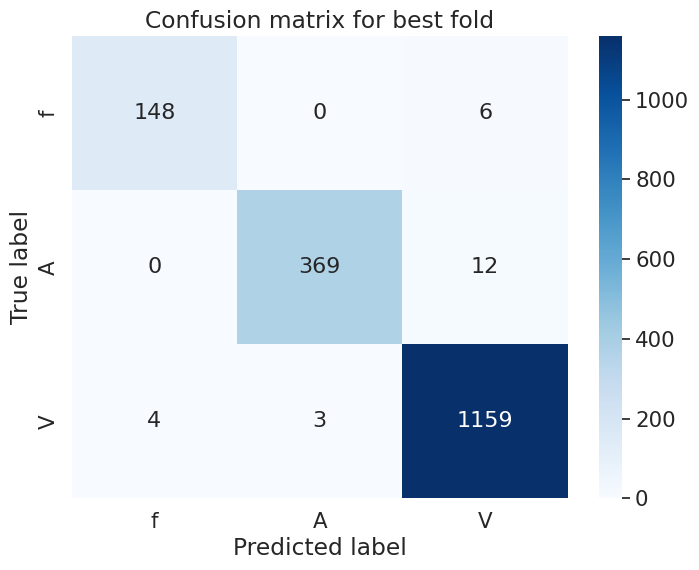

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(best_confusion, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g', xticklabels=['f', 'A', 'V'], yticklabels=['f', 'A', 'V']) # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix for best fold')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from scipy import signal as sig
from sklearn.metrics import confusion_matrix, recall_score
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Flatten, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity


# Convert the features list to a dataframe
df_features = pd.DataFrame(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_features, Y_all, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input features for CNN
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define learning rate
learning_rate = 0.001
momentum = 0.9
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Define the model
num_classes
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_reshaped.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with binary crossentropy, adam optimizer, and custom metrics
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', specificity])

# Convert multilabel-indicator to multiclass
label_encoder = LabelEncoder()
y_train_multiclass = np.argmax(y_train, axis=1)
y_train_multiclass = label_encoder.fit_transform(y_train_multiclass)

# Convert multiclass labels to one-hot encoding
num_classes = len(abnormal_category)
y_train_onehot = to_categorical(y_train_multiclass, num_classes=num_classes)

# Define the number of folds for cross-validation
num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# Initialize lists to store the results
acc_per_fold = []
loss_per_fold = []
spec_per_fold = []
sens_per_fold = []
classification_reports = []
confusion_matrics = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, val_index in kfold.split(X_train_reshaped, y_train_multiclass):
    train_X, val_X = X_train_reshaped[train_index], X_train_reshaped[val_index]
    train_y, val_y = y_train_onehot[train_index], y_train_onehot[val_index]
    # Fit the model on the current fold's training data, with early stopping
    history = model.fit(train_X, train_y, batch_size=64, epochs=100, callbacks=[early_stopping], validation_data=(val_X, val_y))

    # Evaluate the model on the current fold's test data
    scores = model.evaluate(val_X, val_y)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]} of {scores[2]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    spec_per_fold.append(scores[2] * 100)


    # Make predictions on validation set
    Y_pred = model.predict(val_X)
    Y_pred_labels = np.argmax(Y_pred, axis=1)
    Y_true_labels = np.argmax(val_y, axis=1)

    #calculate sensitifity
    sensitivity = recall_score(Y_true_labels, Y_pred_labels, average='macro')
    sens_per_fold.append(sensitivity * 100)

    # Generate classification report and confusion matrix for the current fold
    report = classification_report(Y_true_labels, Y_pred_labels, target_names= abnormal_category)
    # report += f"\nSpecificity: {spec:.2f}"
    confusion = confusion_matrix(Y_true_labels, Y_pred_labels)
    classification_reports.append(report)
    confusion_matrics.append(confusion)
    mean_conf_matrix = np.sum(confusion_matrics, axis=0)

    # Calculate sensitivity for every abnormal_category
    sensitivities = []
    for i in range(len(abnormal_category)):
        true_positives = mean_conf_matrix[i, i]
        false_negatives = np.sum(mean_conf_matrix[i, :]) - true_positives
        sensitivity = true_positives / (true_positives + false_negatives)
        sensitivities.append(sensitivity)

    # Calculate specificities for every abnormal_category
    specificities = []
    for i in range(len(abnormal_category)):
        true_negatives = np.sum(mean_conf_matrix) - np.sum(mean_conf_matrix[i, :]) - np.sum(mean_conf_matrix[:, i]) + mean_conf_matrix[i, i]
        false_positives = np.sum(mean_conf_matrix[:, i]) - mean_conf_matrix[i, i]
        specificity = true_negatives / (true_negatives + false_positives)
        specificities.append(specificity)



    # Increase fold number
    fold_no += 1

# Calculate the average accuracy and loss over all folds
avg_acc = np.mean(acc_per_fold)
avg_loss = np.mean(loss_per_fold)
avg_spec = np.mean(spec_per_fold)
avg_sens = np.mean(sens_per_fold)

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {avg_acc}%')
print(f'> Loss: {avg_loss}')
print(f'> specificity: {avg_spec}%')
print(f'> Sensitivity: {avg_sens:}%')

# Print the best accuracy and loss values and the corresponding classification report
best_fold = np.argmax(acc_per_fold)
best_acc = acc_per_fold[best_fold]
best_loss = loss_per_fold[best_fold]
best_spec = spec_per_fold[best_fold]
best_sens = sens_per_fold[best_fold]
best_report = classification_reports[best_fold]
best_confusion = confusion_matrics[best_fold]
print('------------------------------------------------------------------------')
print(f'Best results obtained in fold {best_fold+1}:')
print(f'> Accuracy: {best_acc}%')
print(f'> Loss: {best_loss}')
print(f'> specificity: {best_spec}')
print(f'> Sensitivity: {best_sens}')
print('Classification Report:')
print(best_report)

# Print the best sensitivities for every abnormal_category
for i in range(len(abnormal_category)):
    print(f"Sensitivity ({abnormal_category[i]}): {sensitivities[i]}")
print('')
print('==================================================================')
print('')
# Print the best specificities for every abnormal_category
for i in range(len(abnormal_category)):
    print(f"Specificity ({abnormal_category[i]}): {specificities[i]}")

Epoch 1/100
107/107 [==============================] - 1s 5ms/step - loss: 0.5792 - accuracy: 0.6102 - specificity: 0.8840 - val_loss: 0.4404 - val_accuracy: 0.7496 - val_specificity: 0.9255
Epoch 2/100
107/107 [==============================] - 0s 3ms/step - loss: 0.4556 - accuracy: 0.7166 - specificity: 0.8892 - val_loss: 0.3924 - val_accuracy: 0.7854 - val_specificity: 0.9284
Epoch 3/100
107/107 [==============================] - 0s 3ms/step - loss: 0.4153 - accuracy: 0.7420 - specificity: 0.8962 - val_loss: 0.3666 - val_accuracy: 0.7942 - val_specificity: 0.9080
Epoch 4/100
107/107 [==============================] - 0s 3ms/step - loss: 0.3964 - accuracy: 0.7553 - specificity: 0.9003 - val_loss: 0.3490 - val_accuracy: 0.7942 - val_specificity: 0.9082
Epoch 5/100
107/107 [==============================] - 0s 3ms/step - loss: 0.3749 - accuracy: 0.7673 - specificity: 0.9032 - val_loss: 0.3335 - val_accuracy: 0.8031 - val_specificity: 0.9111
Epoch 6/100
107/107 [========================

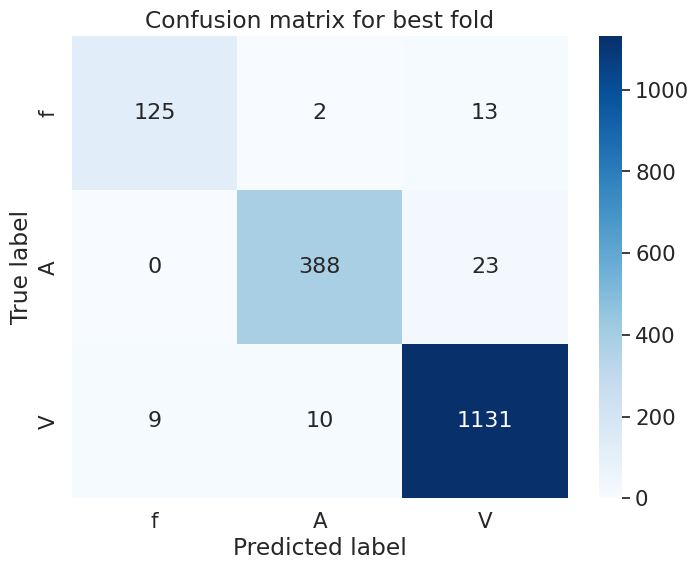

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(best_confusion, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g', xticklabels=['f', 'A', 'V'], yticklabels=['f', 'A', 'V']) # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix for best fold')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from scipy import signal as sig
from sklearn.metrics import confusion_matrix, recall_score
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Flatten, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity


# Convert the features list to a dataframe
df_features = pd.DataFrame(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_features, Y_all, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input features for CNN
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define learning rate
learning_rate = 0.001
rho = 0.9
optimizer = RMSprop(learning_rate=learning_rate, rho=rho)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Define the model
num_classes
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_reshaped.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with binary crossentropy, adam optimizer, and custom metrics
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', specificity])

# Convert multilabel-indicator to multiclass
label_encoder = LabelEncoder()
y_train_multiclass = np.argmax(y_train, axis=1)
y_train_multiclass = label_encoder.fit_transform(y_train_multiclass)

# Convert multiclass labels to one-hot encoding
num_classes = len(abnormal_category)
y_train_onehot = to_categorical(y_train_multiclass, num_classes=num_classes)

# Define the number of folds for cross-validation
num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# Initialize lists to store the results
acc_per_fold = []
loss_per_fold = []
spec_per_fold = []
sens_per_fold = []
classification_reports = []
confusion_matrics = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, val_index in kfold.split(X_train_reshaped, y_train_multiclass):
    train_X, val_X = X_train_reshaped[train_index], X_train_reshaped[val_index]
    train_y, val_y = y_train_onehot[train_index], y_train_onehot[val_index]
    # Fit the model on the current fold's training data, with early stopping
    history = model.fit(train_X, train_y, batch_size=64, epochs=100, callbacks=[early_stopping], validation_data=(val_X, val_y))

    # Evaluate the model on the current fold's test data
    scores = model.evaluate(val_X, val_y)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]} of {scores[2]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    spec_per_fold.append(scores[2] * 100)


    # Make predictions on validation set
    Y_pred = model.predict(val_X)
    Y_pred_labels = np.argmax(Y_pred, axis=1)
    Y_true_labels = np.argmax(val_y, axis=1)

    #calculate sensitifity
    sensitivity = recall_score(Y_true_labels, Y_pred_labels, average='macro')
    sens_per_fold.append(sensitivity * 100)

    # Generate classification report and confusion matrix for the current fold
    report = classification_report(Y_true_labels, Y_pred_labels, target_names= abnormal_category)
    # report += f"\nSpecificity: {spec:.2f}"
    confusion = confusion_matrix(Y_true_labels, Y_pred_labels)
    classification_reports.append(report)
    confusion_matrics.append(confusion)
    mean_conf_matrix = np.sum(confusion_matrics, axis=0)

    # Calculate sensitivity for every abnormal_category
    sensitivities = []
    for i in range(len(abnormal_category)):
        true_positives = mean_conf_matrix[i, i]
        false_negatives = np.sum(mean_conf_matrix[i, :]) - true_positives
        sensitivity = true_positives / (true_positives + false_negatives)
        sensitivities.append(sensitivity)

    # Calculate specificities for every abnormal_category
    specificities = []
    for i in range(len(abnormal_category)):
        true_negatives = np.sum(mean_conf_matrix) - np.sum(mean_conf_matrix[i, :]) - np.sum(mean_conf_matrix[:, i]) + mean_conf_matrix[i, i]
        false_positives = np.sum(mean_conf_matrix[:, i]) - mean_conf_matrix[i, i]
        specificity = true_negatives / (true_negatives + false_positives)
        specificities.append(specificity)



    # Increase fold number
    fold_no += 1

# Calculate the average accuracy and loss over all folds
avg_acc = np.mean(acc_per_fold)
avg_loss = np.mean(loss_per_fold)
avg_spec = np.mean(spec_per_fold)
avg_sens = np.mean(sens_per_fold)

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {avg_acc}%')
print(f'> Loss: {avg_loss}')
print(f'> specificity: {avg_spec}%')
print(f'> Sensitivity: {avg_sens:}%')

# Print the best accuracy and loss values and the corresponding classification report
best_fold = np.argmax(acc_per_fold)
best_acc = acc_per_fold[best_fold]
best_loss = loss_per_fold[best_fold]
best_spec = spec_per_fold[best_fold]
best_sens = sens_per_fold[best_fold]
best_report = classification_reports[best_fold]
best_confusion = confusion_matrics[best_fold]
print('------------------------------------------------------------------------')
print(f'Best results obtained in fold {best_fold+1}:')
print(f'> Accuracy: {best_acc}%')
print(f'> Loss: {best_loss}')
print(f'> specificity: {best_spec}')
print(f'> Sensitivity: {best_sens}')
print('Classification Report:')
print(best_report)

# Print the best sensitivities for every abnormal_category
for i in range(len(abnormal_category)):
    print(f"Sensitivity ({abnormal_category[i]}): {sensitivities[i]}")
print('')
print('==================================================================')
print('')
# Print the best specificities for every abnormal_category
for i in range(len(abnormal_category)):
    print(f"Specificity ({abnormal_category[i]}): {specificities[i]}")

Epoch 1/100
107/107 [==============================] - 2s 10ms/step - loss: 0.3422 - accuracy: 0.8023 - specificity: 0.9172 - val_loss: 0.1877 - val_accuracy: 0.9095 - val_specificity: 0.9556
Epoch 2/100
107/107 [==============================] - 0s 4ms/step - loss: 0.2022 - accuracy: 0.8958 - specificity: 0.9502 - val_loss: 0.1197 - val_accuracy: 0.9424 - val_specificity: 0.9715
Epoch 3/100
107/107 [==============================] - 0s 4ms/step - loss: 0.1528 - accuracy: 0.9222 - specificity: 0.9623 - val_loss: 0.1047 - val_accuracy: 0.9506 - val_specificity: 0.9754
Epoch 4/100
107/107 [==============================] - 0s 4ms/step - loss: 0.1391 - accuracy: 0.9303 - specificity: 0.9657 - val_loss: 0.0979 - val_accuracy: 0.9459 - val_specificity: 0.9730
Epoch 5/100
107/107 [==============================] - 0s 4ms/step - loss: 0.1229 - accuracy: 0.9393 - specificity: 0.9703 - val_loss: 0.0922 - val_accuracy: 0.9500 - val_specificity: 0.9751
Epoch 6/100
107/107 [=======================

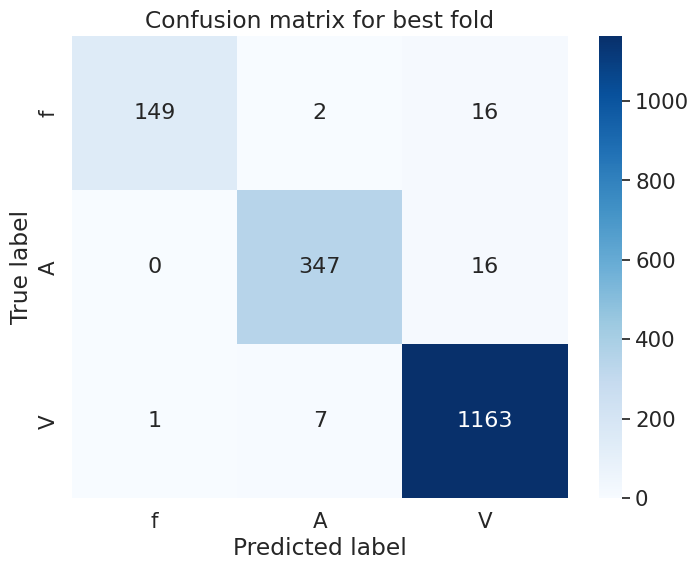

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(best_confusion, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g', xticklabels=['f', 'A', 'V'], yticklabels=['f', 'A', 'V']) # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix for best fold')
plt.show()

Algoritma DNN Klasifikasi terbaik dengan parameter
*   epochs=100
*   batch_size=64
*   learning rate 0,001
*   optimizer adam
dengan hasil akurasi 98.5302746295929%

Best results obtained in fold 4: adam
> Accuracy: 98.5302746295929%

> Loss: 0.030546817928552628

> specificity: 99.30555820465088

> Sensitivity: 97.45131558383675

Best results obtained in fold 3: SGD
> Accuracy: 96.64903283119202%

> Loss: 0.06166472285985947

> specificity: 98.40856194496155

> Sensitivity: 94.0124777722366

Best results obtained in fold 2:
> Accuracy: 97.53086566925049%

> Loss: 0.0510052889585495

> specificity: 98.78472089767456

> Sensitivity: 94.71022220520507